<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">
# 03b - An Example Reproducible Document

## Table of Contents

1. [Introduction](#introduction)
2. [Python Imports/Startup](#python_imports)
3. [Biological Motivation](#motivation)
4. [Load Sequence](#load_sequence)
5. [Build `BLAST` database](#build_blast)
6. [Run `BLAST` query](#blast_query)
7. [Load `BLAST` results](#blast_results)
8. [Query `UniProt`](#uniprot)
9. [Query `KEGG`](#uniprot)
10. [Share The Document](#share)

<a id="introduction"></a>
## 1. Introduction

<p></p><div class="alert-success">
<b>This notebook is an example of what could be done in part `03b - Building a Reproducible Document` if more time was available.</b>
</div>

It is provided as a reference against which you can check your work from notebook `03b`, and inspect to get ideas for how you can use the same techniques and methods in your own research.

<a id="python_imports"></a>
## 2. Python Imports/Startup

<p></p><div class="alert-success">
<b>It can be very convenient to have all the `Python` library imports at the top of the notebook.</b>
</div>

This is very helpful when running the notebook with, e.g. `Cell -> Run All` or `Kernel -> Restart & Run All` from the menu bar, all the libraries are available throughout the document.

In [1]:
# The line below allows the notebooks to show graphics inline
%pylab inline

import io                            # This lets us handle streaming data
import os                            # This lets us communicate with the operating system

import pandas as pd                  # This lets us use dataframes
import seaborn as sns                # This lets us draw pretty graphics

# Biopython is a widely-used library for bioinformatics
# tasks, and integrating with software
from Bio import SeqIO                # This lets us handle sequence data
from Bio.KEGG import REST            # This lets us connect to the KEGG databases

# The bioservices library allows connections to common
# online bioinformatics resources
from bioservices import UniProt      # This lets us connect to the UniProt databases

from IPython.display import Image    # This lets us display images (.png etc) from code

Populating the interactive namespace from numpy and matplotlib


<p></p><div class="alert-success">
<b>It can be useful here to create any output directories that will be used throughout the document.</b>
</div>

The `os.makedirs()` function allows us to create a new directory, and the `exist_ok` option will prevent the notebook code from stopping and throwing an error if the directory already exists.

In [2]:
# Create a new directory for notebook output
OUTDIR = os.path.join("data", "reproducible", "output")
os.makedirs(OUTDIR, exist_ok=True)

<p></p><div class="alert-success">
<b>It can be useful here to create helper functions that will be used throughout the document.</b>
</div>

The `to_df()` function will turn tabular data into a `pandas` dataframe

In [3]:
# A small function to return a Pandas dataframe, given tabular text
def to_df(result):
    return pd.read_table(io.StringIO(result), header=None)

<a id="motivation"></a>
## 3. Biological Motivation

<p></p><div class="alert-info">
<b>We are working on a project to improve bacterial throughput for biosynthesis, and have been provided with a nucleotide sequence of a gene of interest.
<br></br><br></br>
This gene is overrepresented in populations of bacteria that appear to be associated with enhanced metabolic function relevant to a biosynthetic output (lipid conversion to ethanol).
<br></br><br></br>
We want to find out more about the annotated function and literature associated with this gene, which appears to derive from *Proteus mirabilis*.
</div>

Our plan is to:

1. identify a homologue in a reference isolate of *P. mirabilis*
2. obtain the protein sequence/identifier for the homologue
3. get information about the molecular function of this protein from `UniProt`
4. get information about the metabolic function of this protein from `KEGG`
5. visualise some of the information about this gene/protein

<a id="load_sequence"></a>
## 4. Load Sequence

<p></p><div class="alert-success">
<b>We first load the sequence from a local `FASTA` file, using the `Biopython` `SeqIO` library.</b>
</div>

In the `code` cell below:

* we put the path to the sequence file in the variable `seqfile`
* we load the sequence into the variable `wildtype`

In [4]:
# Define the path to the sequence file (in data/reproducible/sequences)
seqfile = os.path.join("data", "reproducible", "sequences", "lipase.fasta")

# Load the sequence data
wildtype = SeqIO.read(seqfile, 'fasta')

Once the sequence is loaded, we print it to the notebook to check it is correct.

In [5]:
# Print the 'wildtype' sequence
print(wildtype)

ID: candidate
Name: candidate
Description: candidate lipase protein from Proteus mirabilis population
Number of features: 0
Seq('ATGAGCACCAAGTACCCCATCGTGCTGGTGCACGGCCTGGCCGGCTTCAGCGAG...CTG', SingleLetterAlphabet())


To see the sequence in `FASTA` format, we can use the `.format()` method:

In [6]:
# Print the 'wildtype' sequence as a FASTA formatted sequence
print(wildtype.format('fasta'))
print(len(wildtype))

>candidate lipase protein from Proteus mirabilis population
ATGAGCACCAAGTACCCCATCGTGCTGGTGCACGGCCTGGCCGGCTTCAGCGAGATCGTG
GGCTTCCCCTACTTCTACGGCATCGCCGACGCCCTGACCCAGGACGGCCACCAGGTGTTC
ACCGCCAGCCTGAGCGCCTTCAACAGCAACGAGGTGAGGGGCAAGCAGCTGTGGCAGTTC
GTGCAGACCATCCTGCAGGAGACCCAGACCAAGAAGGTGAACTTCATCGGCCACAGCCAG
GGCCCCCTGGCCTGCAGGTACGTGGCCGCCAACTACCCCGACAGCGTGGCCAGCGTGACC
AGCATCAACGGCGTGAACCACGGCAGCGAGATCGCCGACCTGTACAGGAGGATCATCAGG
AAGGACAGCATCCCCGAGTACATCGTGGAGAAGGTGCTGAACGCCTTCGGCACCATCATC
AGCACCTTCAGCGGCCACAGGGGCGACCCCCAGGACGCCATCGCCGCCCTGGAGAGCCTG
ACCACCGAGCAGGTGACCGAGTTCAACAACAAGTACCCCCAGGCCCTGCCCAAGACCCCC
TGCGGCGAGGGCGACGAGATCGTGAACGGCGTGCACTACTACTGCTTCGGCAGCTACATC
CAGGAGCTGATCGCCGGCGAGAACGGCAACCTGCTGGACCCCACCCACGCCGCCATGAGG
GTGCTGAACACCCTGTTCACCGAGAAGCAGAACGACGGCCTGGTGGGCAGGTGCAGCATG
AGGCTGGGCAAGCTGATCAAGGACGACTACGCCCAGGACCACTTCGACATGGTGAACCAG
GTGGCCGGCCTGGTGAGCTACAACGAGAACATCGTGGCCATCTACACCCTGCACGCCAAG
TACCTGGCCAGCAAGCAGCTG

861


<a id="build_blast"></a>
## 5. Build `BLAST` Database

<p></p><div class="alert-success">
<b>We now build a local `BLAST` database from the *P. mirabilis* reference proteins.</b>
</div>

* to do this, we run terminal commands in the notebook by using the "*magic*" command `%%bash` at the top of the `code` cell
* using the `%%bash` command makes the rest of the lines in the cell work as though they were the command-line terminal

We build a `BLAST` protein database from the file `data/reproducible/sequences/GCA_000069965.1_ASM6996v1_protein.faa` using the `makeblastdb` command.

<p></p><div class="alert-info">
The output from this command is printed in the notebook below the cell when it runs.
</div>

In [7]:
%%bash
# Drop out to bash to create the BLAST database

# Make a BLAST protein database
makeblastdb -in data/reproducible/sequences/GCA_000069965.1_ASM6996v1_protein.faa \
            -dbtype prot \
            -title reference_protein \
            -out data/reproducible/output/reference_protein



Building a new DB, current time: 04/16/2017 15:07:01
New DB name:   /Users/lpritc/Development/GitHub/Teaching-SfAM-ECR/workshop/data/reproducible/output/reference_protein
New DB title:  reference_protein
Sequence type: Protein
Deleted existing Protein BLAST database named /Users/lpritc/Development/GitHub/Teaching-SfAM-ECR/workshop/data/reproducible/output/reference_protein
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 3662 sequences in 0.141593 seconds.


<a id="blast_query"></a>
## 6. Run `BLAST` Query

<p></p><div class="alert-success">
<b>We now query the wildtype sequence against our custom `BLAST` database from the *P. mirabilis* reference proteins.</b>
</div>

* to do this, we again run terminal commands in the notebook by using the "*magic*" command `%%bash` at the top of the `code` cell

We `BLASTX` the nucleotide sequence query against the `BLAST` protein database in `data/reproducible/output/reference_protein`.

<p></p><div class="alert-info">
We set the `BLAST` output format to `6` (tabular) format, so we can read it in with `pandas`.
<br></br><br></br>
<b>The `BLASTX` command does not produce output in the notebook, if it is successful</b>
<br></br><br></br>
We have named the `BLASTX` output file in such a way that we can tell what the query was, what the database was, and which `BLAST` program was used. This makes it easier to identify results when looking through output files.
</div>

In [8]:
%%bash
# Drop out to bash to run the BLASTX query

blastx -query data/reproducible/sequences/lipase.fasta \
        -db data/reproducible/output/reference_protein \
        -outfmt 6 \
        -out data/reproducible/output/wildtype_blastx_reference_protein.tab

<a id="blast_results"></a>
## 7. Load `BLAST` Results

<p></p><div class="alert-success">
<b>We now load the `BLASTX` results for inspection and visualisation, using `pandas`</b>
</div>

* we use the `pandas` `read_csv()` function to load the tabular data that was created using the option `-outfmt 6` in the `blastx` command
* we define column headers, to make the tabular results easier to understand

<p></p><div class="alert-info">
The tabular format is tab-separated, so we need to specify `sep="\t"` as the separator.
<br></br><br></br>
The tabular output has no header row, so we need to specify `header=None`
<br></br><br></br>
We add column headers to the dataframe *after* it is loaded
</div>

In [9]:
# Define the path to the output file
blastfile = os.path.join("data", "reproducible", "output",
                         "wildtype_blastx_reference_protein.tab")

# Define column headers
# These are the default columns produced with -outfmt 6
headers = ['query', 'subject',
           'pc_identity', 'aln_length',
           'mismatches', 'gaps_opened',
           'query_start', 'query_end',
           'subject_start', 'subject_end',
           'e_value', 'bitscore']

# Load the BLAST output into a dataframe
results = pd.read_csv(blastfile, sep="\t", header=None)
results.columns = headers

We can now inspect the first few rows of the dataframe, to see what the best hits were in the reference genome:

In [10]:
# Show first few rows of the dataframe
results.head()

,query,subject,pc_identity,aln_length,mismatches,gaps_opened,query_start,query_end,subject_start,subject_end,e_value,bitscore
0,candidate,CAR42190.1,95.122,287,14,0,1,861,1,287,0.00,567.0
1,candidate,CAR41557.1,28.947,76,44,3,598,795,93,168,0.59,28.1
2,candidate,CAR45487.1,34.043,47,31,0,235,375,131,177,0.78,27.7
3,candidate,CAR42262.1,43.478,23,13,0,727,795,191,213,1.60,26.9
4,candidate,CAR42804.1,32.258,31,21,0,721,813,33,63,3.10,24.3


There is a single best match - `CAR42190.1` - that aligns over the full length of the candidate sequence (`861/3 = 287`) with 95% identity and 14 residue mismatches.

It is very likely that this protein shares the same molecular and metabolic function as our candidate sequence, so we proceed to query the `UniProt` and `KEGG` databases.

<a id="uniprot"></a>
## 8. Query `UniProt`

<p></p><div class="alert-success">
<b>We now query the `UniProt` databases for information on our best match</b>
</div>

* we use the `bioservices` library to make a connection to the remote `UniProt` servers, and make our query
* we ask for the query results to be returned as a `pandas` dataframe, for ease of processing

<p></p><div class="alert-info">
We set up a connection to the service with the `UniProt()` class, putting this in a variable called `service`
<br></br><br></br>
We can make many queries to the same service, using the `.search()` method
<br></br><br></br>
The default results from `UniProt` can be quite sparse, so we'll ask for them in a different format shortly.
</div>

In [11]:
# Make a link to the UniProt webservice
service = UniProt()

# Make a new query string, and run a remote search for the UniProt entry
query = "CAR42190"
result = service.search(query)

# Inspect the result
print(result)

Entry	Entry name		Protein names	Gene names	Organism	Length
B4EVM3	B4EVM3_PROMH	unreviewed	Putative lipase (EC 3.1.1.3)	PMI0999	Proteus mirabilis (strain HI4320)	287



This result tells us that the `UniProt` record for this sequence has the accession `B4EVM3` (not the `CAR42190` that we first thought), and that it is a putative lipase sequence that has been assigned the Enzyme Classification number `EC 3.1.1.3`.

<p></p><div class="alert-warning">
<b>The `UniProt` output tells us that the gene name of record for this sequence is `PMI0999`. This will be important for our `KEGG` query.</b>
</div>

* the EC number will also be useful when querying `KEGG` later

<p></p><div class="alert-success">
<b>We can also ask for the query results to be returned as a `pandas` dataframe, for ease of processing, with the `service.get_df()` function:</b>
</div>

In [12]:
# Get a dataframe from UniProt
uniprot_df = service.get_df(query)

# View the dataframe
uniprot_df.head()

,Entry,Entry name,Gene names,Gene names (primary ),Gene names (synonym ),Gene names (ordered locus ),Gene names (ORF ),Organism,Organism ID,Protein names,...,Miscellaneous [CC],Keywords,Protein existence,Unnamed: 93,Sequence annotation (Features),Protein families,Version,Comments,Cross-reference (null),Pathway.1
0,B4EVM3,B4EVM3_PROMH,[PMI0999],NaN,NaN,PMI0999,NaN,Proteus mirabilis (strain HI4320),529507,Putative lipase (EC 3.1.1.3),...,NaN,"[3D-structure, Calcium, Complete proteome, Hyd...",Evidence at protein level,unreviewed,NaN,[],53,[],NaN,NaN


This dataframe gives us much more information (100 columns of data - we can see the headers with `uniprot_df.columns`) than the initial result. We can see that there is a 3D structure for the protein, and that there is evidence for its existence at the protein level.

<p></p><div class="alert-info">
`UniProt` can provide much more information than this if asked explicitly, using the same syntax as you would at the `UniProt` website.
<br></br><br></br>
We can look at the distribution of enzymes annotated with this EC number across Enterobacterales genera, using a new `UniProt` query, and some useful functions of dataframes.
<br></br><br></br>
To do this, we'll write a function that allows us to pass an EC number, and taxonomic classification, and produces a histogram of how many examples are found per genus.
</div>

In [13]:
# A function to plot the number of enzymes annotated with a given
# EC number, per genus, under a specified taxonomic classification.
def hist_enzymes_by_genus(ec=None, taxon=None):
    """Plots a histogram of enzymes with passed EC number, per
    genus, under the indicated taxon.
    """
    # Ask UniProt for all proteins with EC number under the passed
    # taxon
    query = "ec:%s taxonomy:%s" % (ec, taxon)
    uniprot_df = service.get_df(query)

    # How many sequences are returned?
    print("UniProt reports %i sequences (EC: %s, taxon: %s)" %
          (len(uniprot_df), ec, taxon))
    
    # Create a new column for  the genus of the organism
    uniprot_df['genus'] = uniprot_df['Organism'].str.split().str.get(0)
    
    # Count the number of enzymes per genus
    genus_count = uniprot_df.groupby('genus')['Entry'].count()
    
    # Plot the number of enzymes per genus
    g = sns.barplot(genus_count.index, genus_count);
    g.set_xticklabels(labels=genus_count.index, rotation=45);
    g.set_title("EC: %s, taxon: %s" % (ec, taxon));
    g.set_ylabel("count")
    
    # Return the plot
    return g

UniProt reports 198 sequences (EC: 3.1.1.3, taxon: enterobacterales)


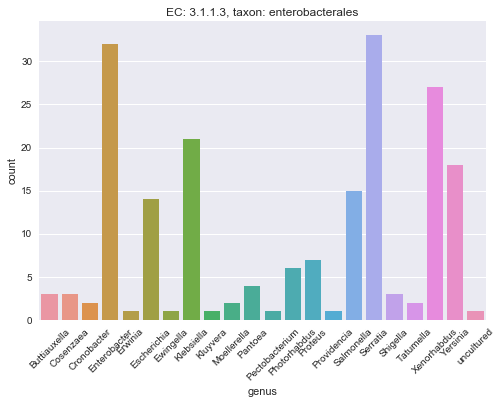

In [14]:
# Call function to plot the number of enzymes in each genus
hist_enzymes_by_genus(ec="3.1.1.3", taxon="enterobacterales");

<a id="kegg"></a>
## 9. Query `KEGG`

<p></p><div class="alert-success">
<b>We now query the `KEGG` databases for information on our best match</b>
</div>

* we use the `Biopython` library to make a connection to the remote `KEGG` servers, and make our query
* we use the `to_df()` function to turn the tabular query results from `KEGG` into a `pandas` dataframe, for ease of processing
* the `UniProt` result tells us that the gene name is `PMI0999`, so we use this as our query
* `KEGG` is composed of several databases, and we need to tell it which database we are serching in, as well as our query

<p></p><div class="alert-info">
We use the `KEGG.REST` module to connect to the `KEGG` databases.
<br></br><br></br>
We first search in the `GENES` database to see what `KEGG` knows about our sequence, and what `KEGG`'s internal ID is (we will need this)
<br></br><br></br>
We use the `REST.kegg_find()` function to identify `KEGG`'s internal identifier for this sequence, so we can access further records
</div>

In [15]:
# Find KEGG GENES result for the query PMI0999
result = REST.kegg_find("genes", "PMI0999").read()     # Do search at KEGG
to_df(result)                                          # convert to a dataframe

,0,1
0,pmr:PMI0999,K01046 triacylglycerol lipase [EC:3.1.1.3] | (...


The first search tells us that `KEGG`'s internal ID for our query sequence is `pmr:PMI0999`.

<p></p><div class="alert-success">
<b>We now use the `REST.kegg_get()` function to extract the record information</b>
</div>

In [16]:
# Get the KEGG GENES entry for pmr:PMI0999
result = REST.kegg_get("pmr:PMI0999").read()
print(result)

ENTRY       PMI0999           CDS       T00753
DEFINITION  (GenBank) putative lipase
ORTHOLOGY   K01046  triacylglycerol lipase [EC:3.1.1.3]
ORGANISM    pmr  Proteus mirabilis HI4320
PATHWAY     pmr00561  Glycerolipid metabolism
            pmr01100  Metabolic pathways
BRITE       KEGG Orthology (KO) [BR:pmr00001]
             Metabolism
              Lipid metabolism
               00561 Glycerolipid metabolism
                PMI0999
            Enzymes [BR:pmr01000]
             3. Hydrolases
              3.1  Acting on ester bonds
               3.1.1  Carboxylic-ester hydrolases
                3.1.1.3  triacylglycerol lipase
                 PMI0999
POSITION    1063081..1063944
MOTIF       Pfam: Abhydrolase_1 DUF676 Lipase_2 DUF915 BAAT_C Hydrolase_4 FliG_N Abhydrolase_6
DBLINKS     NCBI-ProteinID: CAR42190
            UniProt: B4EVM3
STRUCTURE   PDB: 4HS9 3W9U 4GW3 4GXN
AASEQ       287
            MSTKYPIVLVHGLAGFNEIVGFPYFYGIADALRQDGHQVFTASLSAFNSNEVRGKQLWQF
            VQTLLQET

From this entry we can see that:

* our protein is annotated as a triglycerol lipase
* it participates in two metabolic pathways: Glycerolipid metabolism [`pmr00561`] and central metabolism [`pmr01100`]
* the protein has eight annotated motifs in `PFam`
* there are cross-references to several databases, including four structures in RCSB/PDB

<p></p><div class="alert-success">
<b>We want to visualise the pathway that our gene product participates in</b>
</div>

* `KEGG` stores pathways in a separate database to genes, the `PATHWAY` database
* we can use `REST.kegg_get()` to get the text description of a pathway, and also the `KEGG` database image for that pathway.

<p></p><div class="alert-info">
We use the `REST.kegg_get()` function to obtain the pathway entry as text.
</div>

In [17]:
# Get the KEGG PATHWAY entry for our gene in plain text
pathway = REST.kegg_get("pmr00561").read()
print(pathway)

ENTRY       pmr00561                    Pathway
NAME        Glycerolipid metabolism - Proteus mirabilis HI4320
CLASS       Metabolism; Lipid metabolism
PATHWAY_MAP pmr00561  Glycerolipid metabolism
DBLINKS     BSID: 73017
            GO: 0045017 0046486 0046503
ORGANISM    Proteus mirabilis HI4320 [GN:pmr]
GENE        PMI3609  garK; glycerate kinase [KO:K00865] [EC:2.7.1.165]
            PMI2402  dhaK; PTS-dependent dihydroxyacetone kinase, dihydroxyacetone-binding subunit [KO:K05878] [EC:2.7.1.-]
            PMI1231  dhaK1; dihydroxyacetone kinase (glycerone kinase), kinase subunit [KO:K05878] [EC:2.7.1.-]
            PMI1232  dhaK2; dihydroxyacetone kinase, phosphatase subunit [KO:K05879] [EC:2.7.1.-]
            PMI2403  dhaL; PTS-dependent dihydroxyacetone kinase, ADP-binding subunit [KO:K05879] [EC:2.7.1.-]
            PMI3595  gldA; glycerol dehydrogenase [KO:K00005] [EC:1.1.1.6]
            PMI2766  putative glycerol dehydrogenase [KO:K00005] [EC:1.1.1.6]
            PMI3210  gl

This query has given us the full text of the entry, including:

* the identifiers for every enzyme and compound involved in the pathway
* references for literature concerning the pathway
* Gene Ontology (GO) terms associated with the pathway

<p></p><div class="alert-info">
We use the `REST.kegg_get()` function to obtain the pathway entry as an image.
<br></br>
To do this, we need to specify the `"image"` argument when we call the function.
</div>

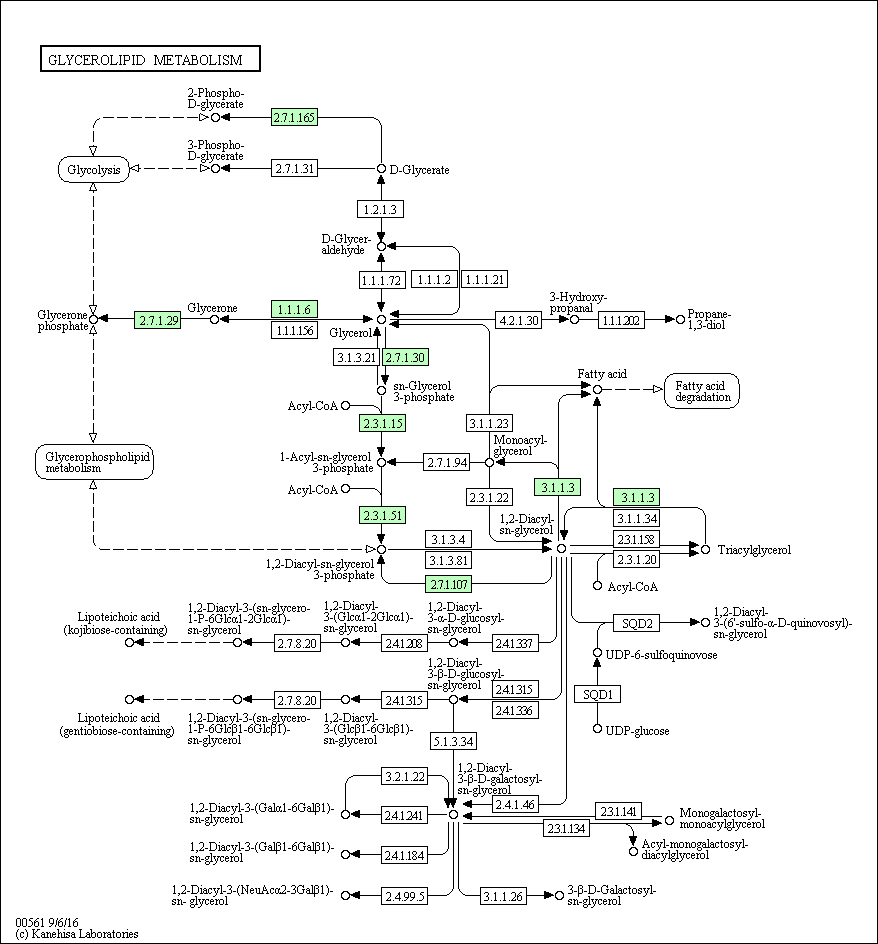

In [18]:
pathway_img = REST.kegg_get("pmr00561", "image").read()
Image(pathway_img)

This now renders the `KEGG` pathway image for `pmr00561`, with the enzymes that are present in our organism (*Proteus mirabilis*) highlighted in green.

<p></p><div class="alert-info">
We can use the `REST.kegg_get()` function in the same way to get a map of central metabolism for *P. mirabilis*:
</div>

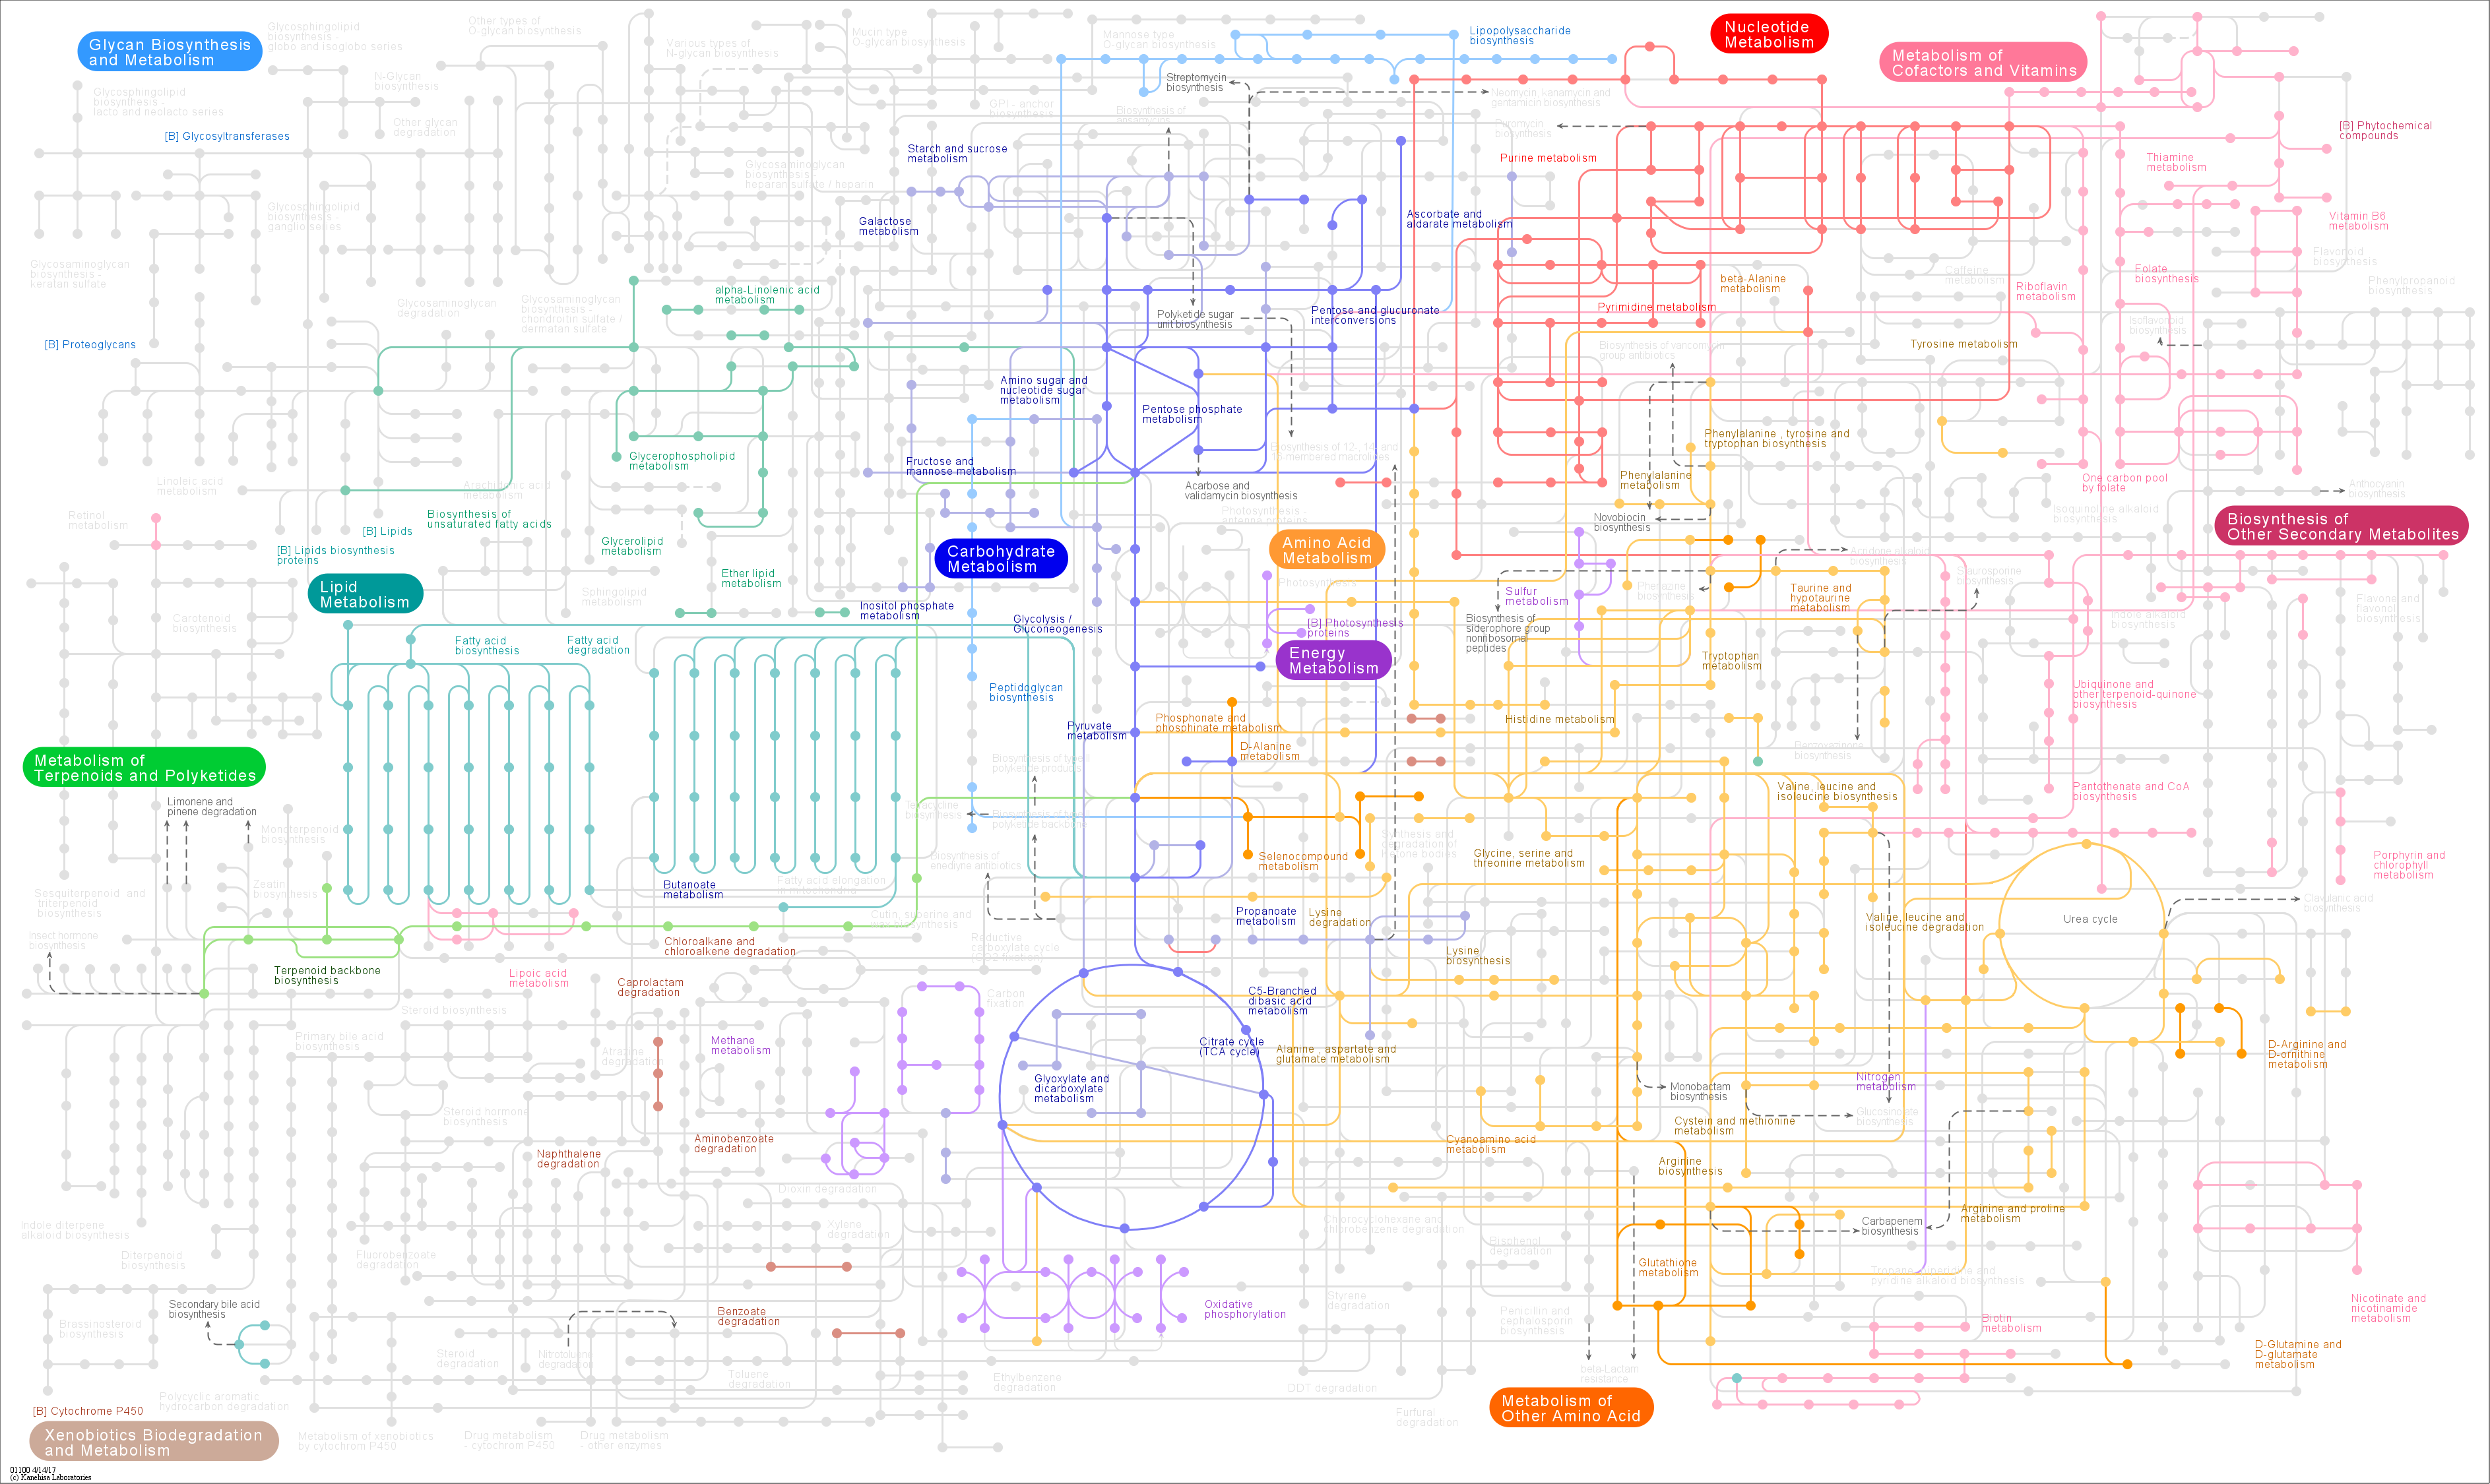

In [19]:
# Get the central metabolism image for P. mirabilis
metabolism_img = REST.kegg_get("pmr01100", "image").read()
Image(metabolism_img)

<a id="share"></a>
## 10. Share The Document

<p></p><div class="alert-success">
<b>Notebooks are convenient for making work reproducible, and part of that is sharing the notebook for reuse.</b>
</div>

We can now share our notebook summarising what we know about our candidate sequence in a number of ways, using the `File -> Download as` options in the menu bar. These are summarised below, with links to example output.

* `Notebook (.ipynb)`: This will allow others to open the notebook and interact with it just as we are doing now, in Jupyter. ([`example.ipynb`](data/reproducible/example_output/example.ipynb))
* `Python (.py)`: This will extract the `Python` code from the notebook into a file that can be run as a plain `Python` script. ([`example.py`](data/reproducible/example_output/example.py))
* `HTML (.html)`: This will render the notebook in HTML format, so it can be viewed, but not interacted with, in a web browser. ([`example.html`](data/reproducible/example_output/example.html))
* `Markdown (.md)`: This will render the notebook in `Markdown` format, so it can be edited as a plaintext document, or converted to a new output format. ([`example.md`](data/reproducible/example_output/example.md))

<p></p><div class="alert-info">
Services such as GitHub can help you share your notebooks and work with a much wider audience.
<br></br>
Where a notebook can help others understand your publication, they can be included as supplementary information, or made available publicly and linked to from your manuscript.
</div>